In [ ]:
import sns
from keras.models import Sequential
from keras.src.layers import MaxPooling2D
from tensorflow.python.layers.convolutional import conv2d
import warnings
import os
import cv2
import numpy as np
import tensorflow as tf
from glob import glob
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
image_resize = 224
my_VGG = Sequential()

In [ ]:
import warnings
warnings.filterwarnings("ignore")  # Ignore les warnings pour éviter les messages inutiles dans la console.

def get_train_test(base_path: str):  # Définition d'une fonction qui charge et prépare les images à partir d'un dossier.
    X = []  # Liste pour stocker les images.
    y = []  # Liste pour stocker les labels.

    label_map = {"NORMAL": 0, "PNEUMONIA": 1}  # Dictionnaire associant les labels aux classes numériques.

    for label in os.listdir(base_path):  # Parcours des dossiers présents dans le répertoire de base.
        if label not in label_map:  # Vérifie que le dossier correspond bien à une classe attendue
            continue  # Si le label ne fait pas partie des classes définies, il est ignoré.

        label_path = os.path.join(base_path, label)  # Création du chemin vers le dossier contenant les images.

        for file_name in os.listdir(label_path):  # Parcours de chaque fichier dans le dossier.
            file_path = os.path.join(label_path, file_name)  # Obtention du chemin complet de l'image.
            img = cv2.imread(file_path)  # Lecture de l'image avec OpenCV.
            if img is None:  # Vérifie que l'image a bien été chargée.
                continue  # Ignore les fichiers qui ne sont pas des images valides.

            img = cv2.resize(img, (image_resize, image_resize), interpolation=cv2.INTER_CUBIC)  # Redimensionne l'image à la taille souhaitée.
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertit l'image du format BGR (OpenCV) à RGB (standard).
            img = img / 255.0  # Normalise les pixels entre 0 et 1 pour améliorer la stabilité du modèle.

            X.append(img)  # Ajoute l'image prétraitée à la liste X.
            y.append(label_map[label])  # Ajoute le label correspondant à la liste y.

    X = np.array(X).reshape(-1, image_resize, image_resize, 3)  # Convertit la liste en tableau NumPy avec la bonne forme (nombre d'images, hauteur, largeur, canaux).
    y = np.array(y).reshape(-1, 1)  # Convertit la liste de labels en tableau NumPy.

    return X, y  # Retourne les tableaux contenant les images et leurs labels.

# Chargement des données d'entraînement et de test.
X_train, y_train = get_train_test("data/chest_xray/train")  # Charge les images pour l'entraînement.
X_test, y_test = get_train_test("data/chest_xray/test")  # Charge les images pour le test.

## test sur le modéle VGG16

In [ ]:
img_shape = (224, 224, 3)
model_VGG16 = VGG16(input_shape=img_shape, include_top=False, weights='imagenet')
model_VGG16.summary()

In [ ]:
# adapter le modèle pour correspondre a nos besoins
model_VGG16.trainable = False

In [ ]:
model_VGG16.output

In [ ]:
# Modifier la couche de sorties
x = Flatten()(model_VGG16.output)
prediction = Dense(1, activation='softmax')(x)

In [ ]:
model = Model(inputs=model_VGG16.input, outputs=prediction)
model.summary()


In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

training_set = train_datagen.flow_from_directory("data/chest_xray/train", target_size=(224, 224), batch_size=32, class_mode='binary')
test_set = test_datagen.flow_from_directory("data/chest_xray/test", target_size=(224, 224), batch_size=32, class_mode='binary')


In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)

meilleure_accuracy_train = max(history.history['accuracy'])
meilleure_accuracy_val = max(history.history['val_accuracy'])
min_loos = min(history.history['loss'])

print(f"Meilleure accuracy (train) : {meilleure_accuracy_train}")
print(f"Meilleure accuracy (validation) : {meilleure_accuracy_val}")
print(f"% le plus bas en loss : {min_loos}")

In [ ]:
# Évaluation du modèle sur les données de test
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=64)

# Affichage des performances sur l'ensemble de test
print(f"Loss sur les données de test : {test_loss}")
print(f"Accuracy sur les données de test : {test_accuracy}")

# Prédictions sur l'ensemble de test
y_pred = model.predict(X_test)

# Conversion des probabilités en classes binaires
y_pred_classes = (y_pred > 0.9).astype("int")  # Seuil fixé à 0.9

# Sélectionner uniquement les images prédites comme PNEUMONIE ET qui sont réellement des PNEUMONIA
indices_pneumonia = np.where((y_pred_classes == 1) & (y_test == 1))[0]

# Vérifier si des indices_pneumonia ont été détectés
if len(indices_pneumonia) == 0:
    print("⚠ Aucun cas de pneumonie  détecté avec le seuil actuel.")
else:
    # Mélange aléatoire des indices des PNEUMONIE détectés
    np.random.shuffle(indices_pneumonia)
    indices_a_afficher = indices_pneumonia[:9]  # Sélectionne jusqu'à 9 images aléatoirement

    # Création d'un affichage en grille 3x3 pour montrer quelques images de test et leurs prédictions.
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    axes = axes.ravel()

    for i in range(len(indices_a_afficher)):
        idx = indices_a_afficher[i]
        axes[i].imshow(X_test[idx])  # Affichage de l'image de test
        axes[i].axis("off")

        label = "PNEUMONIA" if y_pred_classes[idx] == 1 else "NORMAL"
        true_label = "PNEUMONIA" if y_test[idx] == 1 else "NORMAL"

        # Affichage du titre de l'image indiquant la prédiction et la réalité.
        axes[i].set_title(f"Prédit : {label} / Réel : {true_label}", fontsize=8)

    # Masquer les cases vides si moins de 9 images sont affichées
    for i in range(len(indices_a_afficher), 9):
        axes[i].axis("off")

    plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Récupérer les valeurs de l'historique
epochs = range(1, len(history.history['loss']) + 1)
accuracy = history.history['accuracy']
loss = history.history['loss']
val_accuracy = history.history['val_accuracy']
val_loss = history.history['val_loss']

# Création du graphique
plt.figure(figsize=(10, 5))

# Courbe de la loss
plt.plot(epochs, loss, 'r-', label="Loss (train)")
plt.plot(epochs, val_loss, 'r--', label="Loss (val)")

# Courbe de l'accuracy
plt.plot(epochs, accuracy, 'b-', label="Accuracy (train)")
plt.plot(epochs, val_accuracy, 'b--', label="Accuracy (val)")

# Personnalisation du graphique
plt.xlabel("Époques")
plt.ylabel("Valeurs")
plt.title("Évolution de l'accuracy et du loss")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Importation de la matrice de confusion
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Prédictions sur les données de test
y_pred_proba = model.predict(X_test)

# Conversion des probabilités en classes (si softmax ou sigmoid)
y_pred = np.argmax(y_pred_proba, axis=1)  # pour softmax multi-classes
# y_pred = (y_pred_proba > 0.5).astype(int)  # pour binaire (sigmoid)

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

# Affichage
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Prédiction")
plt.ylabel("Vérité")
plt.title("Matrice de confusion")
plt.show()

### Mise en place de ResNet50

In [19]:
import tensorflow as tf
import os
import numpy as np
import cv2
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
image_resize = 224

In [20]:
import warnings
warnings.filterwarnings("ignore")  # Ignore les warnings pour éviter les messages inutiles dans la console.

def get_train_test(base_path: str):  # Définition d'une fonction qui charge et prépare les images à partir d'un dossier.
    X = []  # Liste pour stocker les images.
    y = []  # Liste pour stocker les labels.

    label_map = {"NORMAL": 0, "PNEUMONIA": 1}  # Dictionnaire associant les labels aux classes numériques.

    for label in os.listdir(base_path):  # Parcours des dossiers présents dans le répertoire de base.
        if label not in label_map:  # Vérifie que le dossier correspond bien à une classe attendue
            continue  # Si le label ne fait pas partie des classes définies, il est ignoré.

        label_path = os.path.join(base_path, label)  # Création du chemin vers le dossier contenant les images.

        for file_name in os.listdir(label_path):  # Parcours de chaque fichier dans le dossier.
            file_path = os.path.join(label_path, file_name)  # Obtention du chemin complet de l'image.
            img = cv2.imread(file_path)  # Lecture de l'image avec OpenCV.
            if img is None:  # Vérifie que l'image a bien été chargée.
                continue  # Ignore les fichiers qui ne sont pas des images valides.

            img = cv2.resize(img, (image_resize, image_resize), interpolation=cv2.INTER_CUBIC)  # Redimensionne l'image à la taille souhaitée.
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertit l'image du format BGR (OpenCV) à RGB (standard).
            img = img / 255.0  # Normalise les pixels entre 0 et 1 pour améliorer la stabilité du modèle.

            X.append(img)  # Ajoute l'image prétraitée à la liste X.
            y.append(label_map[label])  # Ajoute le label correspondant à la liste y.

    X = np.array(X).reshape(-1, image_resize, image_resize, 3)  # Convertit la liste en tableau NumPy avec la bonne forme (nombre d'images, hauteur, largeur, canaux).
    y = np.array(y).reshape(-1, 1)  # Convertit la liste de labels en tableau NumPy.

    return X, y  # Retourne les tableaux contenant les images et leurs labels.

# Chargement des données d'entraînement et de test.
X_train, y_train = get_train_test("data/chest_xray/train")  # Charge les images pour l'entraînement.
X_test, y_test = get_train_test("data/chest_xray/test")  # Charge les images pour le test.

In [21]:
# Charger le modèle pré-entraîné sans les couches de classification finales
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Geler les couches du modèle de base pour conserver les poids pré-entraînés
for layer in base_model.layers:
    layer.trainable = False  # On empêche leur entraînement pour éviter d’écraser les connaissances acquises


In [22]:
# Ajout de couches personnalisées sur le modèle pré-entraîné
x = GlobalAveragePooling2D()(base_model.output)  # Permet de réduire la dimension tout en conservant les informations essentielles
x = Dense(512, activation="relu")(x)  # Couche dense avec activation ReLU pour capter des caractéristiques complexes
x = Dropout(0.3)(x)  # Dropout pour réduire l'overfitting
x = Dense(256, activation="relu")(x)  # Autre couche dense pour approfondir la représentation
x = Dropout(0.3)(x)  # Nouveau dropout pour plus de régularisation
x = Dense(128, activation="relu")(x)  # Couche plus petite pour affiner la structure
x = Dropout(0.2)(x)  # Dernière régularisation pour éviter le sur-apprentissage
output = Dense(1, activation="sigmoid")(x)  # Activation sigmoïde pour une classification binaire

# Définition du modèle final
model = Model(inputs=base_model.input, outputs=output)

In [23]:
# Définition de l'optimiseur et de la fonction de perte
optimizer = Adam(learning_rate=0.0005)  # Taux d'apprentissage faible pour assurer une convergence stable
loss_function = "binary_crossentropy"  # Perte adaptée à un problème de classification binaire

# Compilation du modèle
model.compile(optimizer=optimizer, loss=loss_function, metrics=["accuracy"])

In [24]:
# Définition des paramètres d'entraînement
batch_size = 32  # Taille des lots pour une mise à jour efficace des poids
epochs = 40  # Nombre d'époques pour un entraînement progressif
validation_data = (X_test, y_test)  # Données de validation pour éviter l'overfitting

# Entraînement du modèle
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=validation_data)

# Évaluation du modèle après entraînement
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=64)

# Affichage des résultats finaux
print(f"\n🔎 **Résultats après entraînement :**")
print(f"Test Accuracy Maximum : {max(history.history['val_accuracy']) * 100:.2f}%")
print(f"Test Loss Minimum : {min(history.history['val_loss']):.4f}")
print(f"Accuracy sur données de test : {test_accuracy * 100:.2f}%")
print(f"Loss sur données de test : {test_loss:.4f}")


Epoch 1/40
163/163 ━━━━━━━━━━━━━━━━━━━━ 22s 113ms/step - accuracy: 0.6628 - loss: 0.9087 - val_accuracy: 0.6250 - val_loss: 1.1853
Epoch 2/40
163/163 ━━━━━━━━━━━━━━━━━━━━ 16s 99ms/step - accuracy: 0.6433 - loss: 1.1198 - val_accuracy: 0.6314 - val_loss: 0.6379
Epoch 3/40
163/163 ━━━━━━━━━━━━━━━━━━━━ 17s 102ms/step - accuracy: 0.6465 - loss: 1.0923 - val_accuracy: 0.7196 - val_loss: 0.5163
Epoch 4/40
163/163 ━━━━━━━━━━━━━━━━━━━━ 18s 107ms/step - accuracy: 0.7067 - loss: 0.7778 - val_accuracy: 0.7500 - val_loss: 0.5076
Epoch 5/40
163/163 ━━━━━━━━━━━━━━━━━━━━ 17s 104ms/step - accuracy: 0.7689 - loss: 0.6373 - val_accuracy: 0.6843 - val_loss: 0.7831
Epoch 6/40
163/163 ━━━━━━━━━━━━━━━━━━━━ 17s 104ms/step - accuracy: 0.7907 - loss: 0.5379 - val_accuracy: 0.7179 - val_loss: 0.5962
Epoch 7/40
163/163 ━━━━━━━━━━━━━━━━━━━━ 16s 98ms/step - accuracy: 0.7873 - loss: 0.5396 - val_accuracy: 0.7163 - val_loss: 0.6962
Epoch 8/40
163/163 ━━━━━━━━━━━━━━━━━━━━ 17s 103ms/step - accuracy: 0.7930 - loss: 0.5

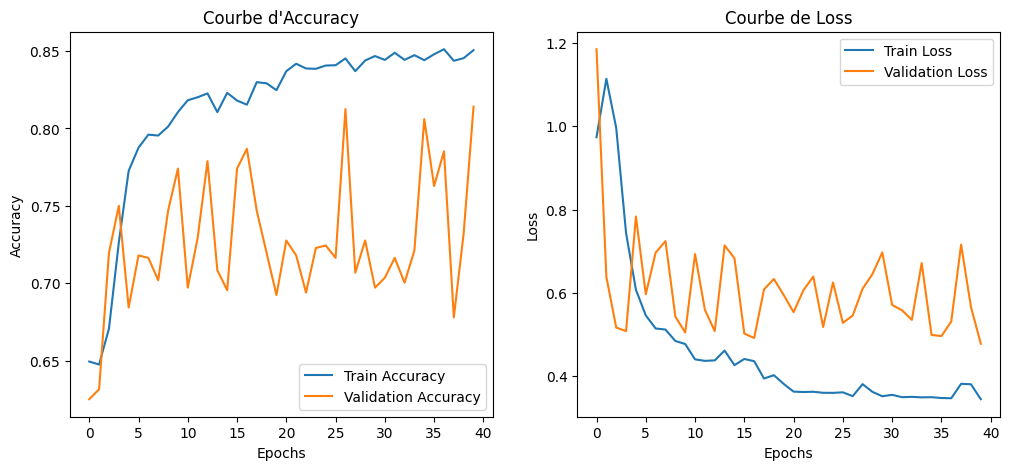

In [25]:
import matplotlib.pyplot as plt

# Récupération des valeurs d'accuracy et de loss
train_acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]

# Création des graphiques
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(train_acc, label="Train Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Courbe d'Accuracy")

# Loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Courbe de Loss")

# Affichage des graphiques
plt.show()

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 175ms/step - accuracy: 0.8576 - loss: 0.4003
Loss sur les données de test : 0.47721007466316223
Accuracy sur les données de test : 0.8141025900840759
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step


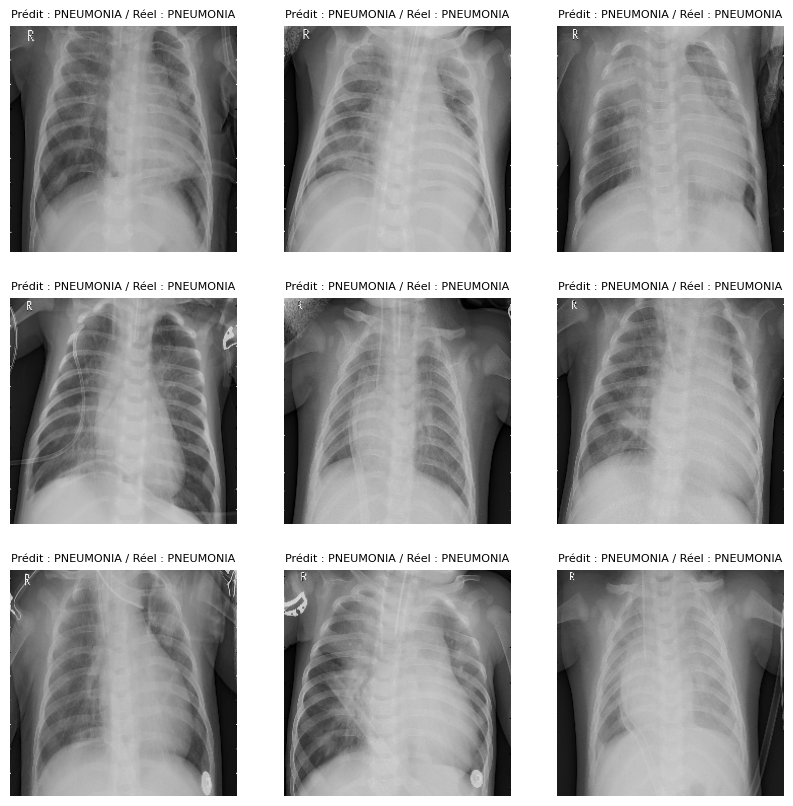

In [26]:
# Évaluation du modèle sur les données de test
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=64)

# Affichage des performances sur l'ensemble de test
print(f"Loss sur les données de test : {test_loss}")
print(f"Accuracy sur les données de test : {test_accuracy}")

# Prédictions sur l'ensemble de test
y_pred = model.predict(X_test)

# Conversion des probabilités en classes binaires
y_pred_classes = (y_pred > 0.9).astype("int")  # Seuil fixé à 0.9

# Sélectionner uniquement les images prédites comme PNEUMONIE ET qui sont réellement des PNEUMONIA
indices_pneumonia = np.where((y_pred_classes == 1) & (y_test == 1))[0]

# Vérifier si des indices_pneumonia ont été détectés
if len(indices_pneumonia) == 0:
    print("⚠ Aucun cas de pneumonie  détecté avec le seuil actuel.")
else:
    # Mélange aléatoire des indices des PNEUMONIE détectés
    np.random.shuffle(indices_pneumonia)
    indices_a_afficher = indices_pneumonia[:9]  # Sélectionne jusqu'à 9 images aléatoirement

    # Création d'un affichage en grille 3x3 pour montrer quelques images de test et leurs prédictions.
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    axes = axes.ravel()

    for i in range(len(indices_a_afficher)):
        idx = indices_a_afficher[i]
        axes[i].imshow(X_test[idx])  # Affichage de l'image de test
        axes[i].axis("off")

        label = "PNEUMONIA" if y_pred_classes[idx] == 1 else "NORMAL"
        true_label = "PNEUMONIA" if y_test[idx] == 1 else "NORMAL"

        # Affichage du titre de l'image indiquant la prédiction et la réalité.
        axes[i].set_title(f"Prédit : {label} / Réel : {true_label}", fontsize=8)

    # Masquer les cases vides si moins de 9 images sont affichées
    for i in range(len(indices_a_afficher), 9):
        axes[i].axis("off")

    plt.show()
